https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

In [1]:
import logging
import numpy as np
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

Automatically created module for IPython interactive environment
Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
data_directory = "drive/My Drive/MTP/data/"

In [ ]:
preprocessed_train_tsv = data_directory + "preprocessed_train.tsv"  #remove ‘content/’ from path then use 
train_data = pd.read_csv(preprocessed_train_tsv, sep='\t')
#X_valid = vectorizer.fit_transform(valid_data['Text'].to_numpy())
X_train_file = []
for index, row in train_data.iterrows():
  X_train_file.append(row['Text'])
X_train_file = np.array(X_train_file)
y_train_file = train_data['Label'].to_numpy()

In [ ]:
validation_tsv = data_directory + "preprocessed_valid.tsv"  #remove ‘content/’ from path then use 
valid_data = pd.read_csv(validation_tsv, sep='\t')
#X_valid = vectorizer.fit_transform(valid_data['Text'].to_numpy())
X_valid_file = []
for index, row in valid_data.iterrows():
  X_valid_file.append(row['Text'])
X_valid_file = np.array(X_valid)
y_valid_file = valid_data['Label'].to_numpy()

In [ ]:
data_train = X_train_file

data_test = X_valid_file

print('data loaded')

target_names = [0, 1]

def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train)
data_test_size_mb = size_mb(data_test)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = y_train_file, y_valid_file

print("Extracting features from the training data using a tfidf vectorizer")
t0 = time()
#max_df=0.0005, min_df=0.000144175,
vectorizer = TfidfVectorizer(sublinear_tf=True,
                              stop_words='english')
X_train = vectorizer.fit_transform(data_train)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

data loaded
6936 documents - 0.979MB (training set)
1000 documents - 0.140MB (test set)
2 categories

Extracting features from the training data using a tfidf vectorizer
done in 0.263581s at 3.715MB/s
n_samples: 6936, n_features: 16257

Extracting features from the test data using the same vectorizer
done in 0.021846s at 6.424MB/s
n_samples: 1000, n_features: 16257



In [ ]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    precision_score = metrics.precision_score(y_test, pred)
    print("precision_score:   %0.3f" % precision_score)

    recall_score = metrics.recall_score(y_test, pred)
    print("recall_score:   %0.3f" % recall_score)

    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if True:
        print("confusion matrix:")
        confusion_matrix = metrics.confusion_matrix(y_test, pred)
        print("true\predicted", end='\t')
        print(target_names)
        for p in range(len(confusion_matrix)):
          print(target_names[p], end='\t\t')
          print(confusion_matrix[p])

    print()
    clf_descr = str(clf).split('(')[0]
    if clf_descr in ['SGDClassifier', 'LinearSVC']:
        #curr_params = clf.get_params()
        clf_descr += '_penalty_' + clf.get_params()['penalty']
    return clf_descr, precision_score, recall_score, f1_score, train_time, test_time

In [ ]:
results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))
bkpresults = results

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None, solver='sag',
                tol=0.01)
train time: 0.048s
test time:  0.001s
precision_score:   0.790
recall_score:   0.693
f1_score:   0.738
dimensionality: 16257
density: 1.000000

confusion matrix:
true\predicted	[0, 1]
0		[441  87]
1		[145 327]

Perceptron
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=50, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
train time: 0.014s
test time:  0.001s
precision_score:   0.721
recall_score:   0.722
f1_score:   0.722
dime

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:558: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  '"sag" solver requires many iterations to fit '


test time:  0.298s
precision_score:   0.645
recall_score:   0.786
f1_score:   0.709
confusion matrix:
true\predicted	[0, 1]
0		[324 204]
1		[101 371]

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
train time: 5.649s
test time:  0.059s
precision_score:   0.736
recall_score:   0.792
f1_score:   0.763
confusion matrix:
true\predicted	[0, 1]
0		[394 134]
1		[ 98 374]

L2 penalty
_______________

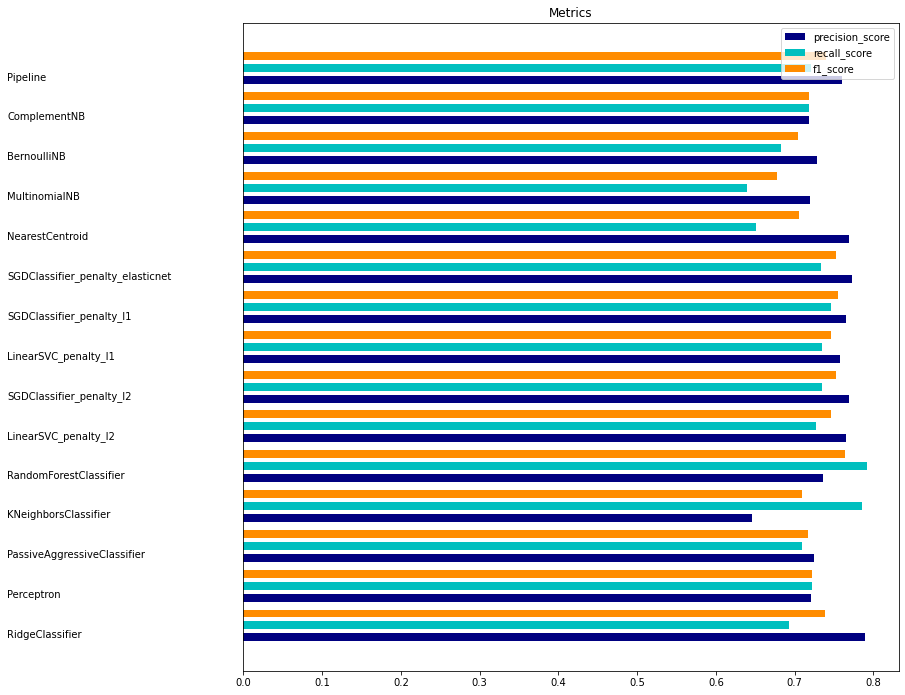

In [ ]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(6)]

clf_names, precision_score, recall_score, f1_score, training_time, test_time = results
#training_time = np.array(training_time) / np.max(training_time)
#test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(14, 10))
plt.title("Metrics")
plt.barh(indices, precision_score, .2, label="precision_score", color='navy')
plt.barh(indices + .3, recall_score, .2, label="recall_score",
         color='c')
plt.barh(indices + .6, f1_score, .2, label="f1_score", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

In [ ]:
df = pd.DataFrame()

In [ ]:
df['Name'] = results[0]
df['Precision'] = results[1]
df['Recall'] = results[2]
df['F1_Score'] = results[3]
df['Training_time'] = results[4]
df['Test_time'] = results[5]

In [ ]:
df

,Name,Precision,Recall,F1_Score,Training_time,Test_time
0,RidgeClassifier,0.789855,0.692797,0.738149,0.047789,0.000623
1,Perceptron,0.720930,0.722458,0.721693,0.014458,0.000588
2,PassiveAggressiveClassifier,0.725108,0.709746,0.717345,0.036819,0.000402
3,KNeighborsClassifier,0.645217,0.786017,0.708691,0.003658,0.298068
4,RandomForestClassifier,0.736220,0.792373,0.763265,5.648965,0.059305
5,LinearSVC_penalty_l2,0.765625,0.726695,0.745652,0.059381,0.000805
6,SGDClassifier_penalty_l2,0.769401,0.735169,0.751896,0.033518,0.000768
7,LinearSVC_penalty_l1,0.757642,0.735169,0.746237,0.203827,0.000904
8,SGDClassifier_penalty_l1,0.765217,0.745763,0.755365,0.060046,0.000828
9,SGDClassifier_penalty_elasticnet,0.772321,0.733051,0.752174,0.081848,0.000769


In [ ]:
df.to_csv(data_directory + 'tfidf_results.tsv', sep='\t')